In [4]:
import os
import sys
import numpy as np
import pandas as pd
import scipy.stats
#%matplotlib widget
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
base_path = os.getcwd()
base_path = base_path.replace('notebooks', 'scripts') # note: if you have notebooks twice in your base_path, this won't work
sys.path.insert(1, base_path)

from helpers import *
from utils import remove_top_right_frame, jitter_scatterplot

# Load data

In [6]:
fname = '/Users/lilly-flore/Desktop/Master-NX/Neuroscience-BIO482/MP-Neurophysiological_data_analysis/NCCM_project/Data/Data_bio482.pkl'
data_df = pd.read_pickle(fname)

# Compute all together

Set general general parameters that we will use

In [7]:
# from part1
free_sweep_type = 'free whisking'
time_window = 2    # time window to analyze Vm (s)
freq_band_lim = [1, 10, 30, 90] # low- and high-frequency band limits (Hz)

# from part2
pre_window = 0.5 # time before whisking onset (s)
post_window = 0.5 # time after whisking onset (s)
min_event_dur = 0.2 # minimal duration of whisking episode to be considered
min_iti = 0.5 # minimal intertrial interval (ITI) between 2 consecutive whisking episode (s)
min_number_trials = 2 # minimal number of trial
bin_size = 0.05 # bin size for psth (s)
epoch_bounds = {'pre':[-0.5, -0.3],
                  'post':[0,0.2]}  # time boundaries to compute changes in whisker protraction (WP), or Vm

#from part3
active_sweep_type = 'active touch'

pre_window = 0.1 # time before touch onset (s)
post_window = 0.3 # time after touch onset (s)
min_event_dur = 0 # minimal duration of active touch episode to be considered
min_iti = 0.2 # minimal intertrial interval (ITI) between 2 consecutive touch episode (s)
min_number_trials = 2 # minimal number of trial
bin_size = 0.01 # bin size for psth (s)
epoch_bounds = {'pre':[-0.05, 0],
                  'post':[0,0.1]}  # time boundaries to compute changes in whisker protraction (WP), or Vm

Select data for specific one sweep type

In [8]:
free_df = data_df[data_df['Sweep_Type']==free_sweep_type] 
active_df = data_df[data_df['Sweep_Type']==active_sweep_type] 

Find all the unique recorded cells present in the data

In [9]:
free_ids = np.unique(free_df.Cell_ID)
active_ids = np.unique(active_df.Cell_ID)
print('Number of free:', len(free_ids))
print('Number of active:', len(active_ids))

# Comparaison directe des ensembles
if set(free_ids) == set(active_ids):
    print('The Cell_IDs are the same in both DataFrames.')
else:
    print('The Cell_IDs are different in the two DataFrames.')
    
    # Afficher les différences détaillées
    free_only = set(free_ids) - set(active_ids)  # IDs dans free_df mais pas dans active_df
    active_only = set(active_ids) - set(free_ids)  # IDs dans active_df mais pas dans free_df

    # Afficher le nombre d'éléments dans chaque différence
    print(f'Number of Cell_IDs in free_df but not in active_df: {len(free_only)}')
    print(f'Number of Cell_IDs in active_df but not in free_df: {len(active_only)}')


    # Afficher le nombre d'éléments dans chaque différence
    print(f'Number of Cell_IDs in free_df but not in active_df: {free_only}')
    print(f'Number of Cell_IDs in active_df but not in free_df: {active_only}\n')


# Identifier les Cell_IDs communs
common_ids = np.intersect1d(free_ids, active_ids)

# Filtrer les DataFrames pour ne garder que les lignes avec les Cell_IDs communs
free_df_filtered = free_df[free_df['Cell_ID'].isin(common_ids)]
active_df_filtered = active_df[active_df['Cell_ID'].isin(common_ids)]

# Vérifier les résultats
print(f'Number of common Cell_IDs: {len(common_ids)}')
print(f'Filtered free_df size: {len(free_df_filtered)}')
print(f'Filtered active_df size: {len(active_df_filtered)}')

Number of free: 232
Number of active: 134
The Cell_IDs are different in the two DataFrames.
Number of Cell_IDs in free_df but not in active_df: 106
Number of Cell_IDs in active_df but not in free_df: 8
Number of Cell_IDs in free_df but not in active_df: {'TK325_1', 'AP060_2', 'TK464_1', 'TK241_1', 'AP061_1', 'CG055_5', 'TK208_1', 'TK507_2', 'TK490_3', 'TK384_1', 'TK480_2', 'TK472_3', 'TK355_2', 'TK333_2', 'TK140_2', 'AP056_1', 'TK254_1', 'CG055_3', 'TK253_1', 'CG016_1', 'TK237_1', 'TK277_1', 'TK506_1', 'TK304_1', 'TK491_2', 'TK413_1', 'TK499_1', 'CG015_1', 'TK408_2', 'TK251_1', 'TK283_1', 'TK278_1', 'AP062_1', 'TK309_1', 'TK316_1', 'TK140_1', 'TK151_1', 'TK247_1', 'TK236_1', 'TK250_2', 'TK181_1', 'CG055_2', 'TK234_1', 'TK150_1', 'TK112_2', 'TK472_2', 'TK208_2', 'TK196_1', 'TK283_2', 'AP069_1', 'TK184_1', 'TK232_1', 'AP035_2', 'AP068_1', 'CG076_1', 'TK272_1', 'TK476_1', 'AP060_1', 'TK292_1', 'TK150_2', 'TK276_1', 'TK405_1', 'TK460_1', 'TK358_1', 'TK250_1', 'AP056_2', 'CG077_1', 'TK146_1

# Analysis

In [10]:
# For now, use all free IDs but once all gathered, use common_ids
all_cells = np.unique(free_df.Cell_ID)

In [11]:
verbose=False #set to 0 to hide individual AP plots

# Initialize a dictionary to store data for all cell
result_dict = {'cell_id': all_cells,  # to be replaced by common_ids
          'cell_type':[], # required for cell-type identification
          # Data we'll collect for Part 1a
          'firing_rate': [], 
          'ap_threshold': [], 
          'ap_duration': [], 
          # Data we'll collect for Part 1b
          'mean_vm':[],
          'std_vm':[],
          'fft_low':[],
          'fft_high':[],
        # This is a template, an example with whisker protraction
          'numb_events': [],
          'wp_avg': [],
          'wp_amplitude_pre': [],
          'wp_amplitude_post': [],
          # Sub. Vm
          'vm_avg': [], 
          'vm_amplitude_pre': [],
          'vm_amplitude_post': [],
          # Firing rates
          'ap_avg':[],
          'ap_psth':[],
          'ap_fr_pre':[],
          'ap_fr_post':[]
        }

result_fft_cell_type = {'EXC':[],'SST':[], 'VIP':[],'PV':[]}

exc_cell_counter = 0

# Iterate over each cell identities to collect desired data
free_cell_list = sorted(np.unique(free_df.Cell_ID), reverse=True) #NOTE: DO NOT START WITH AC32 bc. no AP and undefined ap_params content
for idx, cell in enumerate(free_cell_list):
    if idx%100==0:
        print('Cell {}/{}'.format(idx, np.unique(free_df.Cell_ID).shape[0]))
    
    # Get mouse name and cell number from cell identifier
    mouse = cell.split('_')[0]
    cell_count = float(cell.split('_')[1])
    
    # Get data subset for that cell
    cell_df = free_df[free_df.Cell_ID==cell]
    
    # Get cell type 
    cell_type = cell_df.Cell_Type.values[0]
    result_dict['cell_type'] += [cell_type]
    
    # Get sweeps/trials recorded for that cell, that we are going to iterate over
    trial_list = cell_df.Sweep_Counter.values
    
    # Init. cell recording specific quantities: a unique duration, yielding a unique number of APs
    tot_rec_duration = 0
    tot_number_ap = 0
    
    # Initialize empty lists to get data for each trial/sweep
    # Part 1a
    tot_ap_thresh = []
    tot_ap_duration = []
    # Part 1b
    tot_mean_vm = []
    tot_std_vm = []
    tot_fft = []

    # Part 2
    tot_ap_thresh = []
    tot_ap_duration= []
    
    # Template
    tot_wp_events = []
    
    # Vm and AP FR
    tot_vm_events = []
    tot_ap_events = []
    
    # For that cell, iterate over trials
    for trial in trial_list:
        #if idx % 100 == 0: # print every 100 iteration  
            #print('Cell {},  trial {}'.format(cell, int(trial)))
        if cell_type == 'EXC':
            exc_cell_counter += 1
        
        # Get current trial data
        cell_trial_df = cell_df[cell_df.Sweep_Counter==trial]

        # Get event times for that trial
        event_times = cell_trial_df['Sweep_WhiskingTimes'].values[0]

        if event_times is None: # skip when there are no events
            continue
        
        
        # Get the sampling rate and membrane potential (and derivative) from that sweep
        sr_vm = cell_trial_df['Sweep_MembranePotential_SamplingRate'].values[0] #[0] to get the content of the array
        membrane_potential = cell_trial_df['Sweep_MembranePotential'].values[0]
        ap_vm_deriv_thresh = cell_trial_df['Cell_APThreshold_Slope'].values[0]

        # Template: extract whisker angle and sampling rate of whisker video data
        whisker_angle = cell_trial_df['Sweep_WhiskerAngle'].values[0]
        sr_wp = cell_trial_df['Sweep_WhiskerAngle_SamplingRate'].values[0]
        
        # Get and update recording duration for that cell by adding trial duration
        trial_rec_duration = len(membrane_potential)/sr_vm
        tot_rec_duration += trial_rec_duration
        
        # Detection of action potentials for that trial, and update total number of APs for that cell
        #ap_params = None
        ap_params = Function_Detect_APs(membrane_potential, sr_vm, ap_vm_deriv_thresh) 
        tot_number_ap += ap_params.shape[0]
          
        # Check if this trial contains any AP...
        ap_duration = []
        if (ap_params.any()):
            ap_thresh_times = ap_params[:,0]
            ap_thresh_vm = ap_params[:,1]
            ap_peak_times = ap_params[:,2]
            ap_peak_vm = ap_params[:,3]
            ap_duration = ap_params[:,5] #check for no-APs (cells with no spikes in ALL trials:EXC5,16 FR=0, AP_dur=np.nan)

            #... if so, cut-out individual APs to keep subthreshold Vm only
            vm_sub = Function_CutAPs(membrane_potential, sr_vm, ap_peak_times, ap_thresh_times)
            
            #For APs, make an analog binary vector of same dimensions as Vm_Sub
            vec_length = len(vm_sub)
            ap_vect = Function_Times2Vect(ap_peak_times, sr_vm, vec_length)
            
        # Else if no AP, subthreshold Vm is just Vm
        else:
            vm_sub = membrane_potential.copy()
            ap_vect = np.zeros_like(vm_sub) #empty vector of size Vm_Sub

        # Once Vm_sub is obtained:
        # Compute subthreshold Vm mean and standard deviation
        mean_vm, std_vm = Function_SubThrsVm(vm_sub, sr_vm, trial_rec_duration)
        
        # Compute trial FFT
        fft = Function_Compute_FFTs(vm_sub, sr_vm, time_window)

        # Once trial event times and data is collected, use this function to extract data aligned to event onset
        # -> check function (Function_Event_Triggered_Signal) parameters and code!
        # -> input data can be whatever, given a certain dimensions
        # -> events can be whatever
        # -> adjust sampling rate for data type (e.g. video, Vm)! 
        
        wp_event = Function_Event_Triggered_Signal(whisker_angle, sr_wp, 
                                                   event_times, pre_window, post_window, min_event_dur, min_iti)
        vm_event = Function_Event_Triggered_Signal(vm_sub, sr_vm, 
                                                   event_times, pre_window, post_window, min_event_dur, min_iti)
        ap_event = Function_Event_Triggered_Signal(np.squeeze(ap_vect), sr_vm, 
                                                   event_times, pre_window, post_window, min_event_dur, min_iti)


        # Missing data in original .mat file is encoded as -1, so this skips entires with missing data
        if type(wp_event) == int:
            continue
        if type(vm_event) == int:
            continue
        if type(ap_event) == int:
            continue
        
        #Update current variables from the current trial
        # Part 1a
        tot_ap_thresh += [np.concatenate([ap_thresh_vm])]
        tot_ap_duration += [ap_duration]
        # Part 1b
        tot_mean_vm += [mean_vm]
        tot_std_vm += [std_vm]
        tot_fft +=  [fft]

        # Append each event-triggered vector and stack to an array 
        tot_wp_events += [wp_event]
        tot_wp_array = np.hstack(tot_wp_events)
        
        tot_vm_events+= [vm_event]
        tot_vm_array=np.hstack(tot_vm_events)
        
        tot_ap_events+= [ap_event]
        tot_ap_array=np.hstack(tot_ap_events)
        
        # Optional plotting: show AP and AP peak times
        ap_peak_index=np.round(ap_peak_times * sr_vm)  
        if verbose:
            fig, ax = plt.subplots(1,1, figsize=(10,2), dpi=300)
            remove_top_right_frame(ax)
            ax.set_title('Cell {},  trial {}'.format(cell, int(trial)))
            ax.plot(membrane_potential, lw=0.5,  zorder=0)
            ax.scatter(ap_peak_index, ap_peak_vm, lw=0.5, marker='+', color='r')
            ax.set_xlabel('Time (samples)')
            ax.set_ylabel('Membrane \n potential (V)')
            plt.show()

    # Once iterated over all trials for that cell, append cell data lists to the result dictionary
  
  # Compute means only if a certain number of trials is present
    n_events = tot_wp_array.shape[1]
    if (n_events >= min_number_trials):
        result_dict['numb_events'] += [n_events] 
        
        # Calculate trial-averaged signals
        #Template: WP
        wp_avg = np.mean(tot_wp_array, 1) 
        result_dict['wp_avg'] += [wp_avg] #add for that cell
        
        vm_avg = np.mean(tot_vm_array, 1) 
        result_dict['vm_avg'] += [vm_avg]
        
        ap_avg = np.mean(tot_ap_array, 1) 
        result_dict['ap_avg'] += [ap_avg]
        
        ap_psth=Function_PSTH(ap_avg, sr_vm, pre_window, post_window, bin_size)
        result_dict['ap_psth'] += [ap_psth[:,1]]
        
        
        #for epoch in range(wp_bounds.shape[0]): 
        for epoch in epoch_bounds.keys():
            
            # Template: whisker protraction
            # Get bound of that epoch (pre/post)
            bound_1=int(np.round((epoch_bounds[epoch][0]+pre_window)*sr_wp))
            bound_2=int(np.round((epoch_bounds[epoch][1]+pre_window)*sr_wp-1))
            
            #Get mean in pre/post epoch
            if epoch=='pre':
                result_dict['wp_amplitude_pre'] += [wp_avg[bound_1:bound_2].mean(0)]
            else:
                result_dict['wp_amplitude_post'] += [wp_avg[bound_1:bound_2].mean(0)]
                
            # Vm, and AP firing rate
            bound_1=int(np.round((epoch_bounds[epoch][0]+pre_window)*sr_vm)) #sr_vm !
            bound_2=int(np.round((epoch_bounds[epoch][1]+pre_window)*sr_vm-1))
            
            if epoch=='pre':
                result_dict['vm_amplitude_pre'] += [vm_avg[bound_1:bound_2].mean(0) * 1000] #in mV!
                result_dict['ap_fr_pre'] += [ap_avg[bound_1:bound_2].mean(0) * sr_vm]       #in Hz!
            else:
                result_dict['vm_amplitude_post'] += [vm_avg[bound_1:bound_2].mean(0) * 1000] #in Hz!
                result_dict['ap_fr_post'] += [ap_avg[bound_1:bound_2].mean(0) * sr_vm]
                
                
    #If there are less trials than necessary, set to NaNs (exclude data)
    else:
        result_dict['numb_events'] += [n_events]
        
        #Template: WP
        wp_avg=np.nan*np.empty_like(wp_avg)
        result_dict['wp_avg'] += [wp_avg]
        result_dict['wp_amplitude_pre'] += [np.nan]
        result_dict['wp_amplitude_post'] += [np.nan]
        
        # VM
        vm_avg=np.nan*np.empty_like(vm_avg)
        result_dict['vm_avg'] += [vm_avg]
        result_dict['vm_amplitude_pre'] += [np.nan]
        result_dict['vm_amplitude_post'] += [np.nan]
        
        #AP firing rate
        ap_avg=np.nan*np.empty_like(ap_avg)
        result_dict['ap_avg'] += [ap_avg]
        ap_psth=Function_PSTH(ap_avg, sr_vm, pre_window, post_window, bin_size)
        result_dict['ap_psth'] += [ap_psth[:,1]]
        
        result_dict['ap_fr_pre'] += [np.nan]
        result_dict['ap_fr_post'] += [np.nan]

    # Part 1a
    result_dict['firing_rate'] += [tot_number_ap / tot_rec_duration] # <- just the firing rate formula
    result_dict['ap_threshold'] += [np.nanmean(np.concatenate(tot_ap_thresh))] #<-concatenate trials, get trial-average
    result_dict['ap_duration'] += [np.nanmean(np.concatenate(tot_ap_duration))]

    
    # Part 1b
    result_dict['mean_vm'] += [np.nanmean(np.concatenate(tot_mean_vm))]
    result_dict['std_vm'] += [np.nanmean(np.concatenate(tot_std_vm))]
    
    # Compute mean FFT over trials
    tot_fft = np.nanmean(np.concatenate(tot_fft, axis=1), 1)
    #Store mean cell FFT
    result_fft_cell_type[cell_type] += [tot_fft] 
    
    # We need to find which point (sample) in the FFT correspond to which frequency
    pt1 = int(freq_band_lim[0] * fft.shape[0] / (sr_vm/2) ) + 1 #1Hz into FFT point
    pt2 = int(freq_band_lim[1] * fft.shape[0] / (sr_vm/2) ) + 1 #int: slicing requires integers
    result_dict['fft_low'] += [tot_fft[pt1:pt2].mean()]
    
    pt3 = int(freq_band_lim[2] * fft.shape[0] / (sr_vm/2) ) + 1
    pt4 = int(freq_band_lim[3] * fft.shape[0] / (sr_vm/2) ) + 1 
    result_dict['fft_high'] += [tot_fft[pt3:pt4].mean()]

## Convert each dictionary lists as numpy arrays (convenient to make dataframes)
result_dict = {key: np.array(result_dict[key]) for key in result_dict.keys()}

#Init. dataframe size
result_df = pd.DataFrame(index=range(np.unique(free_df.Cell_ID).shape[0]),
             columns=result_dict.keys())

for key in result_dict.keys():
    result_df[key] = result_dict[key] #this works for scalars
    
# For array-based data, one must give a list to assign to dataframe column
# Template: WP
result_df['wp_avg'] = list(result_dict['wp_avg'])

result_df['vm_avg'] = list(result_dict['vm_avg'])
result_df['ap_avg'] = list(result_dict['ap_avg'])
result_df['ap_psth'] = list(result_dict['ap_psth'])

# times for the bins of the psth
psth_time=ap_psth[:,0]

print('Done!')

Cell 0/232
Cell 100/232


/var/folders/tj/z0dp280955b2cclgs13c8ngm0000gn/T/ipykernel_21589/2924497859.py:271: RuntimeWarning: Mean of empty slice
  result_dict['ap_duration'] += [np.nanmean(np.concatenate(tot_ap_duration))]


Cell 200/232


/Users/lilly-flore/Desktop/Master-NX/Neuroscience-BIO482/MP-Neurophysiological_data_analysis/NCCM_project/scripts/helpers.py:55: RuntimeWarning: invalid value encountered in divide
  sAP_OnOff = np.diff(np.divide(sAP_Seg, np.abs(sAP_Seg)))  # compute the binary signal


Done!


In [12]:
#Template: calculte post-pre difference in WP as a new column to dataframe
result_df['delta_wp'] = result_df['wp_amplitude_post'] - result_df['wp_amplitude_pre']

#Vm and AP firing rate
result_df['delta_vm'] = result_df['vm_amplitude_post'] - result_df['vm_amplitude_pre']
result_df['delta_ap'] = result_df['ap_fr_post'] - result_df['ap_fr_pre']

In [13]:
result_df.columns

Index(['cell_id', 'cell_type', 'firing_rate', 'ap_threshold', 'ap_duration',
       'mean_vm', 'std_vm', 'fft_low', 'fft_high', 'numb_events', 'wp_avg',
       'wp_amplitude_pre', 'wp_amplitude_post', 'vm_avg', 'vm_amplitude_pre',
       'vm_amplitude_post', 'ap_avg', 'ap_psth', 'ap_fr_pre', 'ap_fr_post',
       'delta_wp', 'delta_vm', 'delta_ap'],
      dtype='object')

In [14]:
columns_to_keep = ['cell_id', 'cell_type', 'firing_rate', 'ap_threshold', 'ap_duration',
       'mean_vm', 'std_vm', 'fft_low', 'fft_high', 'vm_amplitude_pre',
       'ap_fr_pre', 'wp_amplitude_pre', 'delta_ap', 'delta_vm', 'delta_wp']

result_df = result_df[columns_to_keep]

In [15]:
result_df = result_df.dropna(axis=0)

In [16]:
result_df.describe() #only sclar numeric columns

,firing_rate,ap_threshold,ap_duration,mean_vm,std_vm,fft_low,fft_high,vm_amplitude_pre,ap_fr_pre,wp_amplitude_pre,delta_ap,delta_vm,delta_wp
count,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000
mean,10.240168,-0.040844,0.821282,-0.054174,0.005114,0.000641,0.000063,-54.037684,10.957275,125.707150,0.414075,-0.175176,6.826362
std,15.223881,0.003296,0.515323,0.005827,0.001548,0.000222,0.000023,6.092178,18.461822,121.781633,8.687594,2.073015,3.525155
min,0.005208,-0.048334,0.223307,-0.069672,0.001333,0.000153,0.000019,-68.430469,0.000000,-159.780039,-34.223082,-6.933812,-1.153705
25%,1.158712,-0.043013,0.471322,-0.057528,0.003940,0.000479,0.000044,-57.466289,0.000000,150.778863,-2.333391,-1.372401,4.487932
50%,4.270151,-0.040938,0.688999,-0.053690,0.005039,0.000626,0.000058,-53.618379,4.004004,190.158975,0.000000,-0.166577,6.442816
75%,14.412500,-0.039061,1.000598,-0.050315,0.006055,0.000776,0.000077,-50.317969,13.346680,195.756921,2.076075,0.879707,8.618514
max,127.119565,-0.028422,3.399151,-0.038182,0.010189,0.001389,0.000130,-33.906306,176.647235,218.998219,33.350008,8.665342,19.118799


In [17]:
result_df.head(1)

,cell_id,cell_type,firing_rate,ap_threshold,ap_duration,mean_vm,std_vm,fft_low,fft_high,vm_amplitude_pre,ap_fr_pre,wp_amplitude_pre,delta_ap,delta_vm,delta_wp
0,AP032_1,EXC,0.875,-0.040795,0.608929,-0.064378,0.005948,0.000763,0.00007,-60.887438,0.0,187.840525,1.429286,-0.105066,2.148964


In [18]:
result_df.shape

(228, 15)

# Classification

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.colors as mcolors

In [20]:
data = result_df.copy()
y = data['cell_type']
X = data.drop(columns=['cell_id', 'cell_type']) 
print(X.shape)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y) 

(228, 13)


### **Logistic Regression for multiclassification EXC, PV, SST, VIP**

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)

model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Test Accuracy: 0.8696

Classification Report:
              precision    recall  f1-score   support

         EXC       0.88      1.00      0.93        14
          PV       0.70      1.00      0.82         7
         SST       1.00      0.73      0.84        22
         VIP       0.75      1.00      0.86         3

    accuracy                           0.87        46
   macro avg       0.83      0.93      0.86        46
weighted avg       0.90      0.87      0.87        46



/Users/lilly-flore/miniconda3/envs/bio482/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [22]:
from sklearn import tree

clf = tree.DecisionTreeClassifier(max_depth=2)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Test Accuracy: 0.7609

Classification Report:
              precision    recall  f1-score   support

         EXC       0.92      0.86      0.89        14
          PV       0.58      1.00      0.74         7
         SST       0.87      0.59      0.70        22
         VIP       0.50      1.00      0.67         3

    accuracy                           0.76        46
   macro avg       0.72      0.86      0.75        46
weighted avg       0.82      0.76      0.76        46



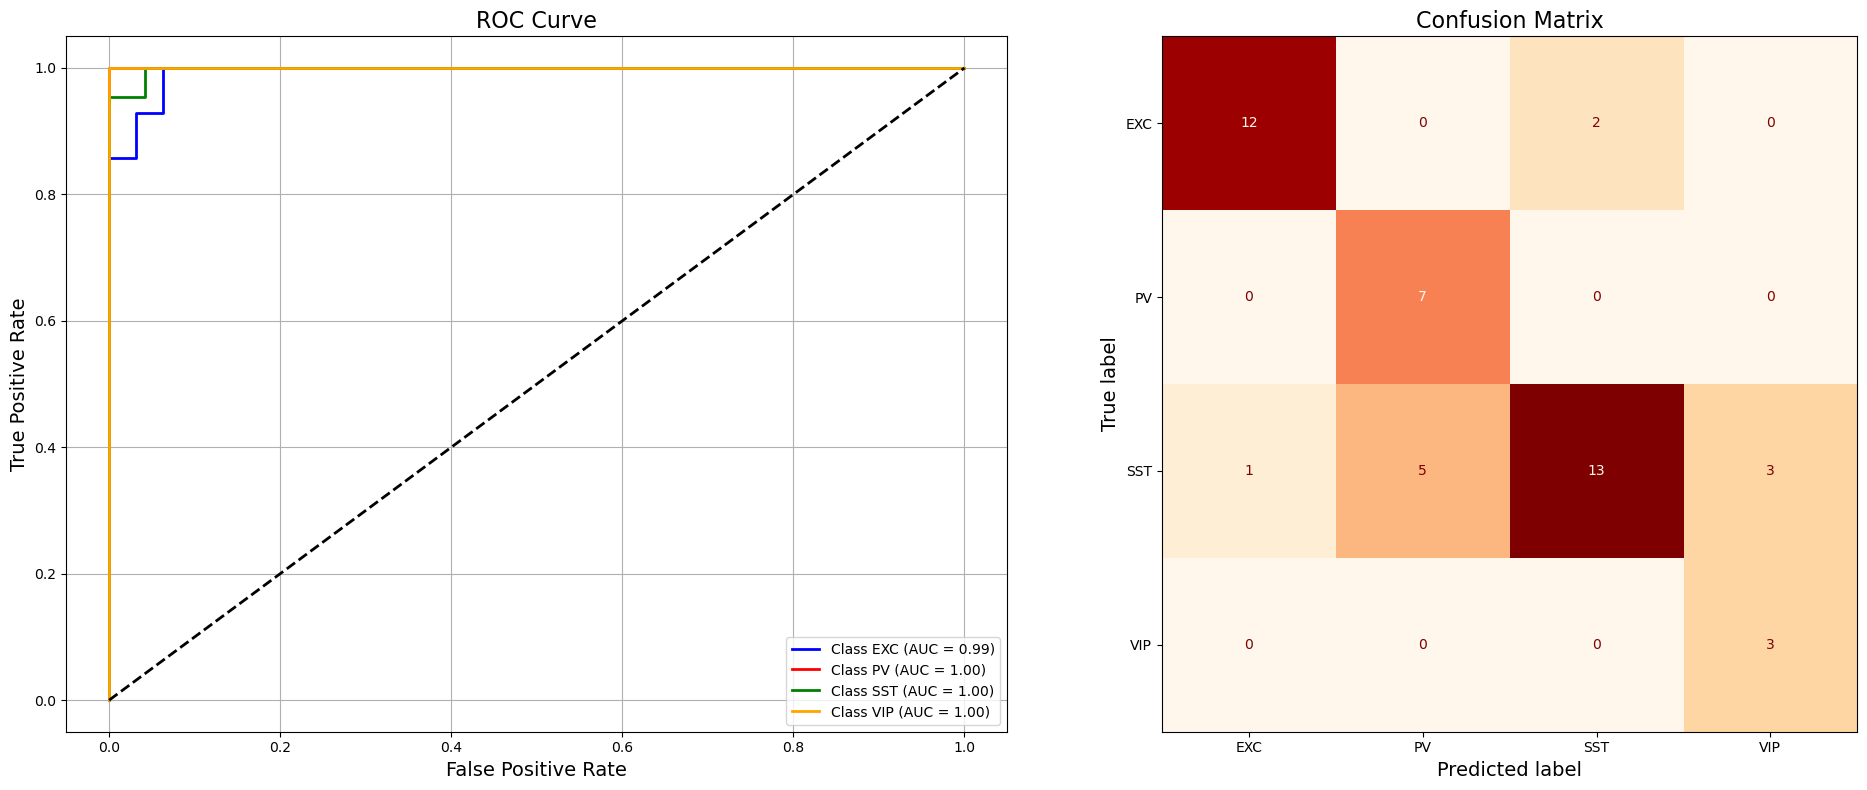

Macro-Averaged AUC: 1.00
Micro-Averaged AUC: 0.98


In [23]:
y_test_binarized = label_binarize(y_test, classes=range(len(label_encoder.classes_)))
n_classes = y_test_binarized.shape[1]

y_score = model.predict_proba(X_test_scaled)

fpr = {}  
tpr = {}  
roc_auc = {}  

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

cm = confusion_matrix(y_test, y_pred)

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

colors = ['blue', 'red', 'green', 'orange']
for i in range(n_classes):
    axes[0].plot(fpr[i], tpr[i], color=colors[i], lw=2,
                 label=f"Class {label_encoder.classes_[i]} (AUC = {roc_auc[i]:.2f})")
axes[0].plot([0, 1], [0, 1], 'k--', lw=2)
axes[0].set_title("ROC Curve", fontsize=16)
axes[0].set_xlabel("False Positive Rate", fontsize=14)
axes[0].set_ylabel("True Positive Rate", fontsize=14)
axes[0].legend(loc="lower right")
axes[0].grid()

# Sous-plot 2 : Matrice de confusion
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(ax=axes[1], cmap='OrRd', colorbar=False)
axes[1].set_title("Confusion Matrix", fontsize=16)
axes[1].set_xlabel("Predicted label", fontsize=14)
axes[1].set_ylabel("True label", fontsize=14)

# Ajuster les espacements
plt.tight_layout()
plt.show()

# Afficher les scores macro et micro AUC
macro_auc = roc_auc_score(y_test_binarized, y_score, multi_class="ovr", average="macro")
micro_auc = roc_auc_score(y_test_binarized, y_score, multi_class="ovr", average="micro")
print(f"Macro-Averaged AUC: {macro_auc:.2f}")
print(f"Micro-Averaged AUC: {micro_auc:.2f}")


In [24]:
model.coef_

array([[-1.49147475,  0.91227134,  1.48220402, -1.29115518, -0.59456478,
         0.69466002, -0.15217872,  0.27998703, -0.36381936,  0.35051536,
        -0.74327161,  0.04835444,  0.04106781],
       [ 0.69178488, -0.41822465, -1.63351606, -0.31722666, -0.32538509,
        -0.00415038,  1.54337477,  0.3732535 ,  1.0735215 , -0.03724269,
         0.1067657 ,  0.29594813, -0.45003033],
       [ 0.3450782 , -0.30818032, -0.25561434,  1.27620035,  0.16841999,
        -0.55850337, -0.18218017, -0.822112  , -1.14688677,  0.1485512 ,
         0.43789517, -0.8018998 ,  0.608857  ],
       [ 0.45461166, -0.18586638,  0.40692638,  0.33218149,  0.75152987,
        -0.13200626, -1.20901588,  0.16887148,  0.43718464, -0.46182387,
         0.19861074,  0.45759723, -0.19989448]])

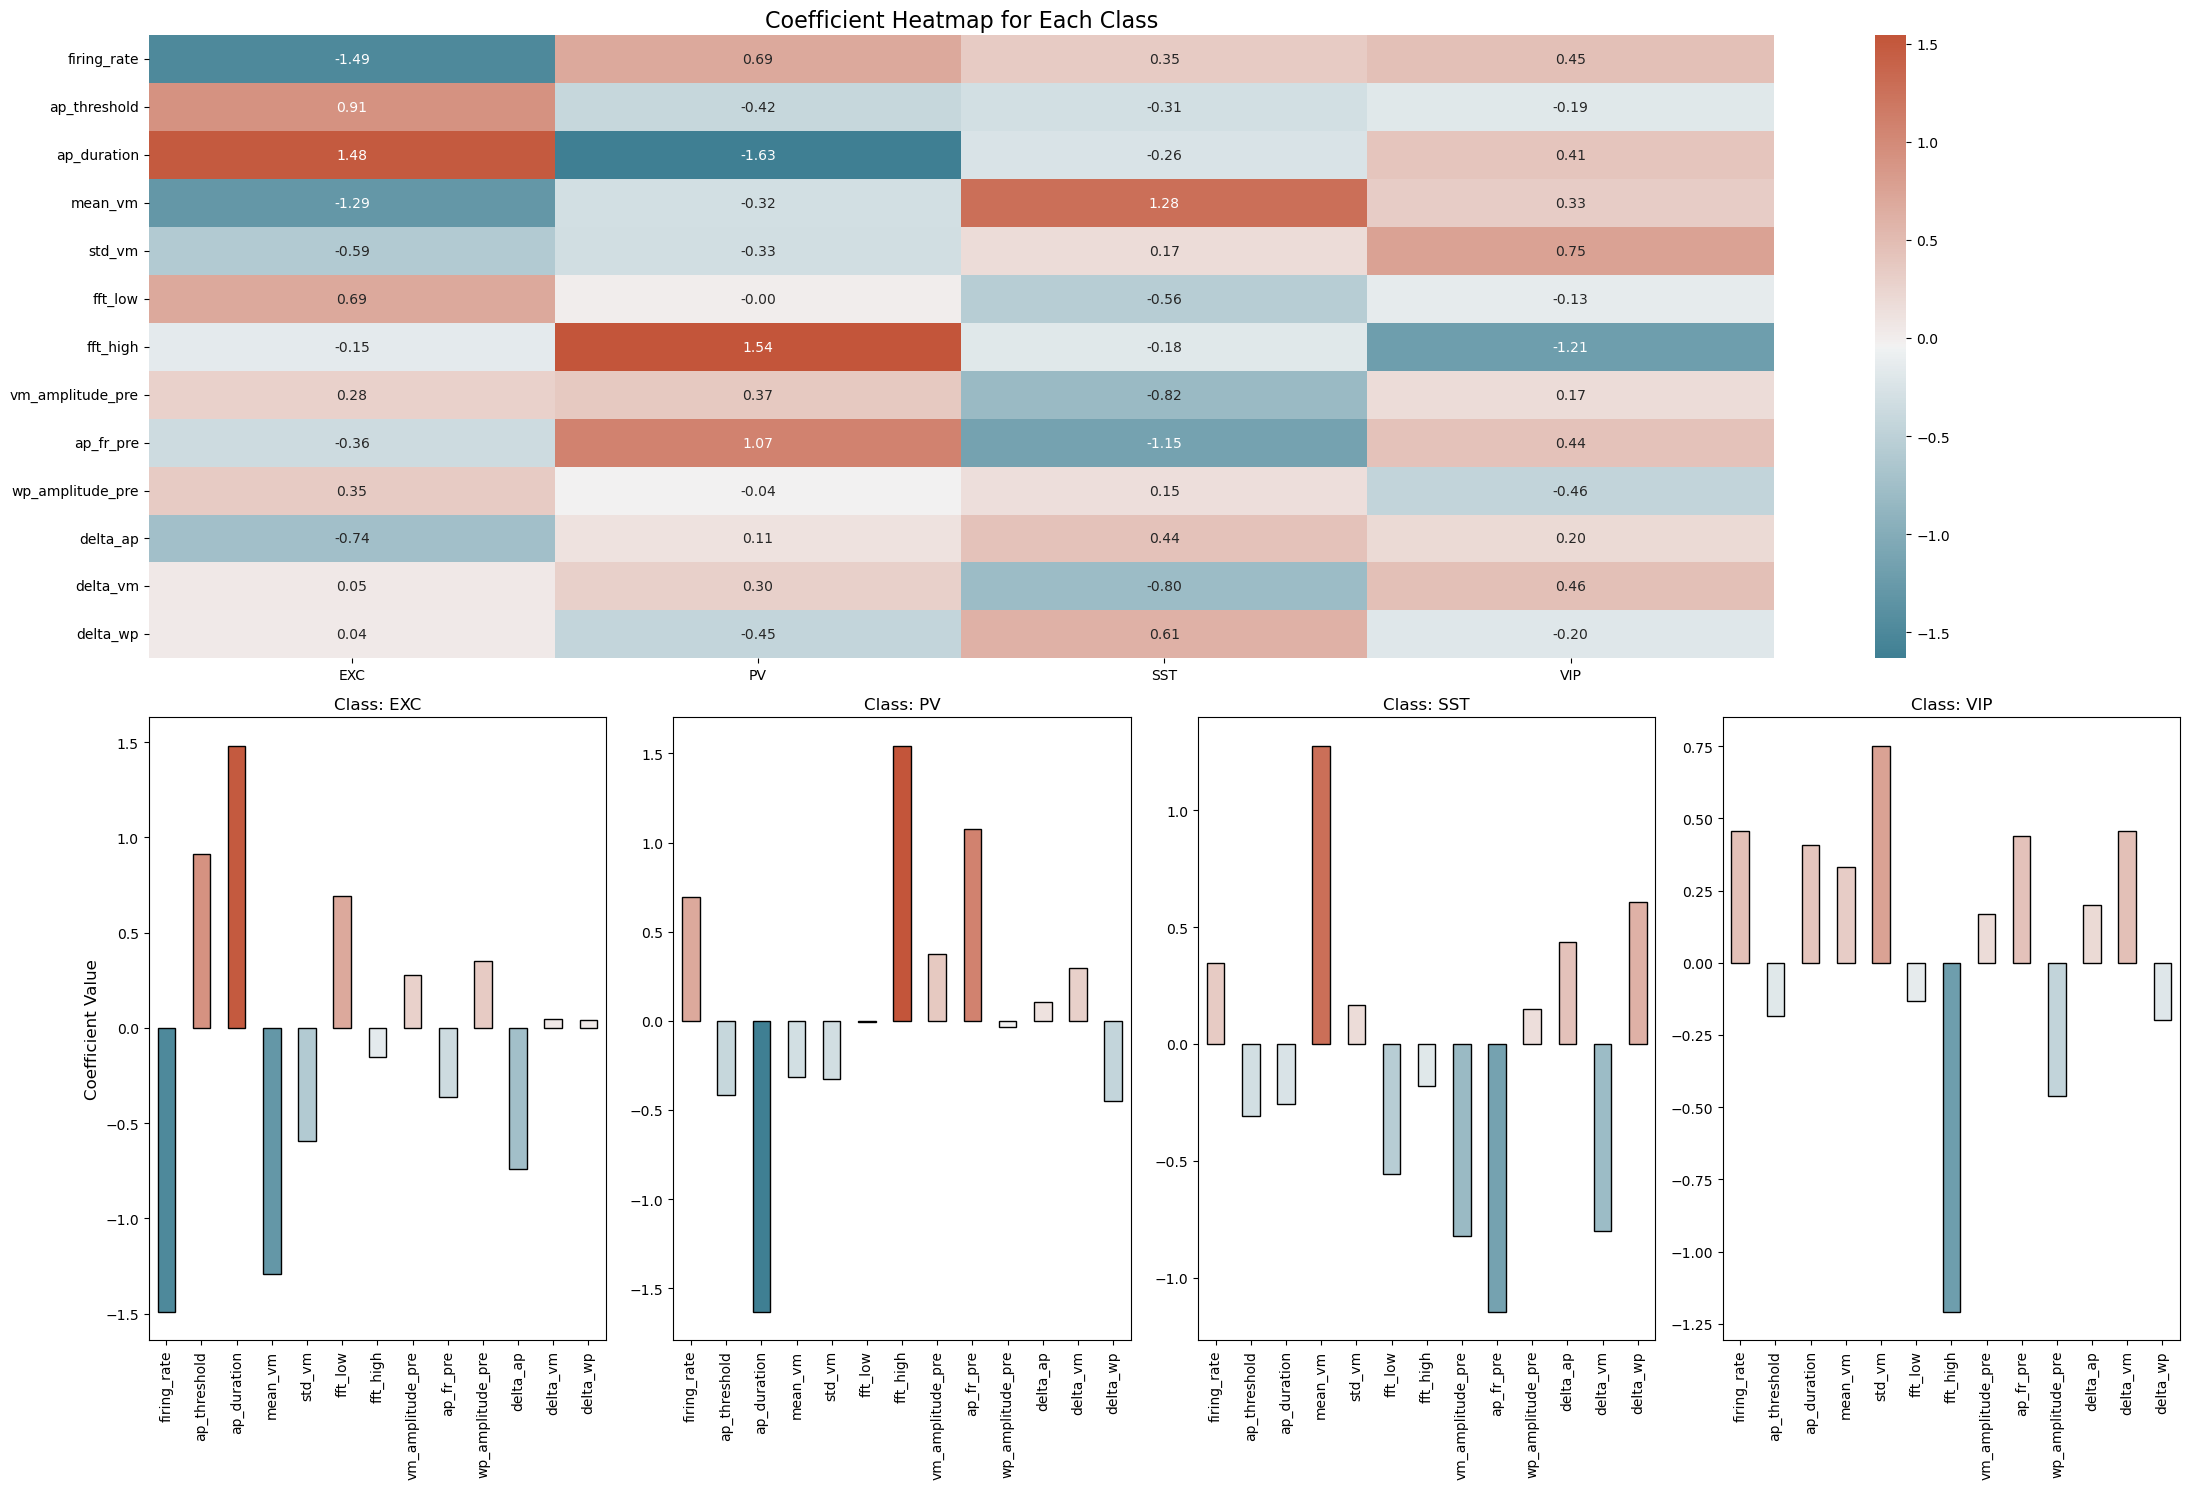

In [25]:
coef_df = pd.DataFrame(model.coef_, columns=X.columns, index=label_encoder.classes_).T

classes = coef_df.columns
n_classes = len(classes)


fig = plt.figure(figsize=(22, 15))


ax1 = plt.subplot(2, 1, 1) 
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(coef_df, annot=True, cmap=cmap, fmt=".2f", ax=ax1)
ax1.set_title('Coefficient Heatmap for Each Class', fontsize=16)

norm = plt.Normalize(vmin=coef_df.min().min(), vmax=coef_df.max().max()) 
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)


ax2 = [plt.subplot(2, n_classes, n_classes + i + 1) for i in range(n_classes)]

for i, ax in enumerate(ax2):
    values = coef_df[classes[i]].values
    colors = [sm.to_rgba(value) for value in values] 
    coef_df[classes[i]].plot(kind='bar', ax=ax, color=colors, edgecolor='black')
    ax.set_title(f'Class: {classes[i]}', fontsize=12)
    if i == 0:
        ax.set_ylabel('Coefficient Value', fontsize=12)
    ax.tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

### **Logistic Regression for binary classification : EXC, INH**

In [26]:
data = result_df.copy()
y = data['cell_type']
y = y.where(y == 'EXC', 'INH')
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
X = data.drop(columns=['cell_id', 'cell_type']) 



X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)

model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Test Accuracy: 0.9783

Classification Report:
              precision    recall  f1-score   support

         EXC       0.93      1.00      0.97        14
         INH       1.00      0.97      0.98        32

    accuracy                           0.98        46
   macro avg       0.97      0.98      0.97        46
weighted avg       0.98      0.98      0.98        46



/Users/lilly-flore/miniconda3/envs/bio482/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


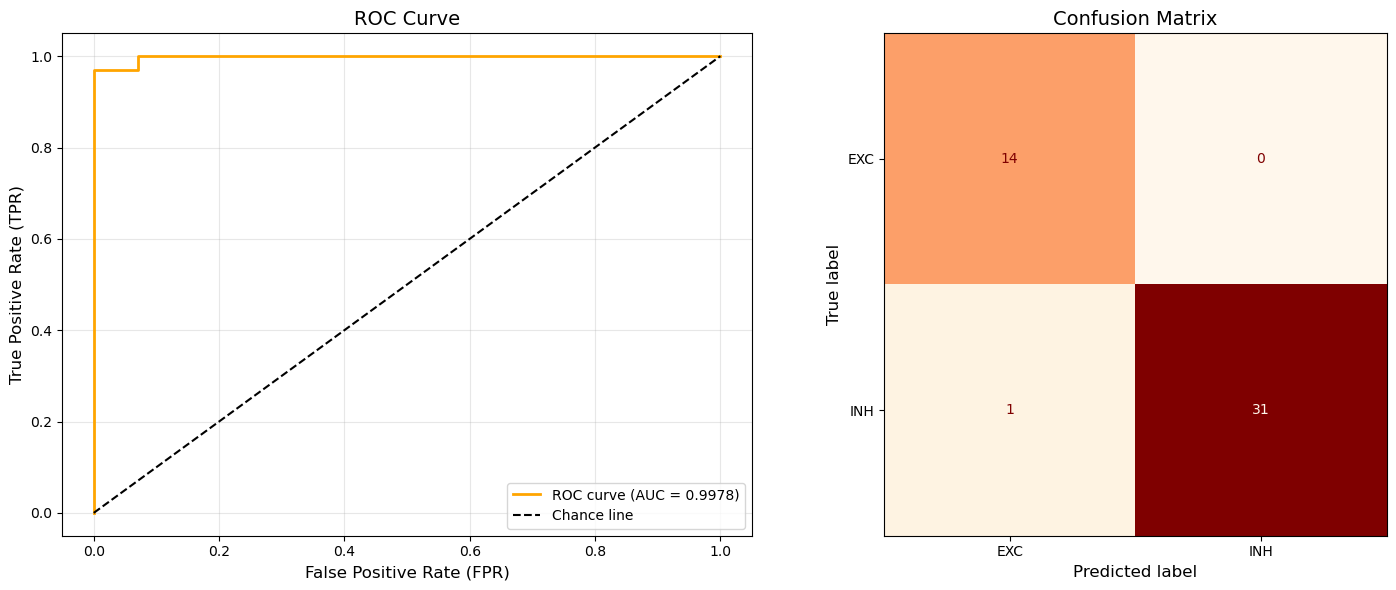

In [27]:
y_prob = model.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
cm = confusion_matrix(y_test, y_pred)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})', linewidth=2, color = "orange")
axes[0].plot([0, 1], [0, 1], 'k--', label='Chance line')  # Ligne de hasard
axes[0].set_title('ROC Curve', fontsize=14)
axes[0].set_xlabel('False Positive Rate (FPR)', fontsize=12)
axes[0].set_ylabel('True Positive Rate (TPR)', fontsize=12)
axes[0].legend(loc='lower right')
axes[0].grid(alpha=0.3)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(ax=axes[1], cmap='OrRd', colorbar=False)
axes[1].set_title('Confusion Matrix', fontsize=14)
axes[1].set_xlabel('Predicted label', fontsize=12)
axes[1].set_ylabel('True label', fontsize=12)

plt.tight_layout()
plt.show()

In [28]:
coefficients = model.coef_.squeeze()
coefficients

array([ 1.10501863, -0.64462274, -0.79336075,  1.07562737,  0.70434058,
       -0.6348469 , -0.01917857, -0.31759829,  0.19619295, -0.32079872,
        0.57550945, -0.15405986,  0.18115588])

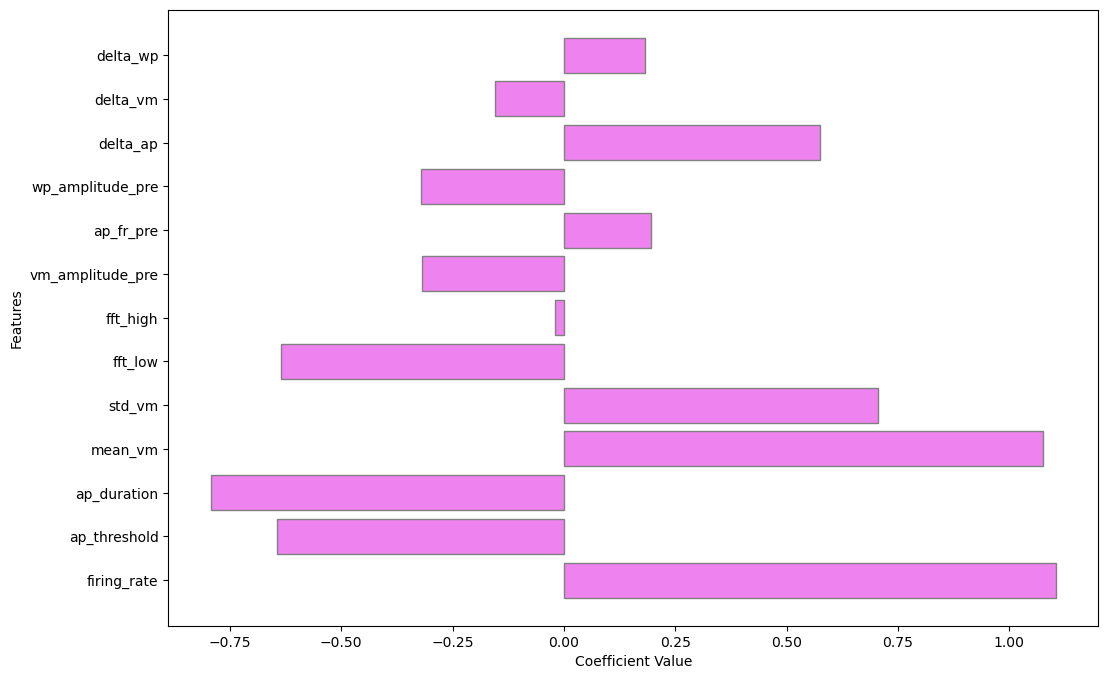

In [29]:
plt.figure(figsize=(12, 8))
plt.barh(list(X.columns), coefficients, color="violet", edgecolor='grey')
plt.ylabel('Features')
plt.xlabel('Coefficient Value')
plt.show()

In [30]:
data = result_df.copy()
y = data['cell_type']
y = y.where(y == 'EXC', 'INH')
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
X = data.drop(columns=['cell_id', 'cell_type']) 

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_scaled, y_train)


rf_predictions = rf_model.predict(X_test_scaled)
print("Random Forest Classification Report:")
print(classification_report(y_test, rf_predictions))
print("Random Forest Accuracy:", accuracy_score(y_test, rf_predictions))
print("Random Forest Confusion Matrix:")
print(confusion_matrix(y_test, rf_predictions))

dt_model = DecisionTreeClassifier(max_depth=2, random_state=42)
dt_model.fit(X_train_scaled, y_train)

dt_predictions = dt_model.predict(X_test_scaled)
print("\nDecision Tree Classification Report:")
print(classification_report(y_test, dt_predictions))
print("Decision Tree Accuracy:", accuracy_score(y_test, dt_predictions))
print("Decision Tree Confusion Matrix:")
print(confusion_matrix(y_test, dt_predictions))


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      1.00      1.00        32

    accuracy                           1.00        46
   macro avg       1.00      1.00      1.00        46
weighted avg       1.00      1.00      1.00        46

Random Forest Accuracy: 1.0
Random Forest Confusion Matrix:
[[14  0]
 [ 0 32]]

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        14
           1       0.97      0.97      0.97        32

    accuracy                           0.96        46
   macro avg       0.95      0.95      0.95        46
weighted avg       0.96      0.96      0.96        46

Decision Tree Accuracy: 0.9565217391304348
Decision Tree Confusion Matrix:
[[13  1]
 [ 1 31]]


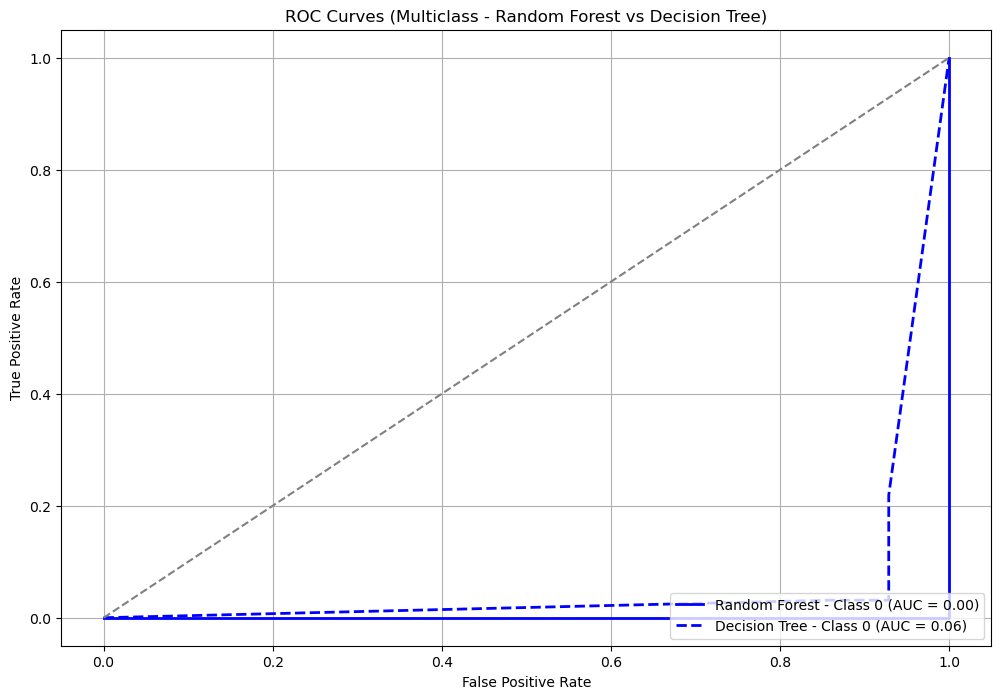

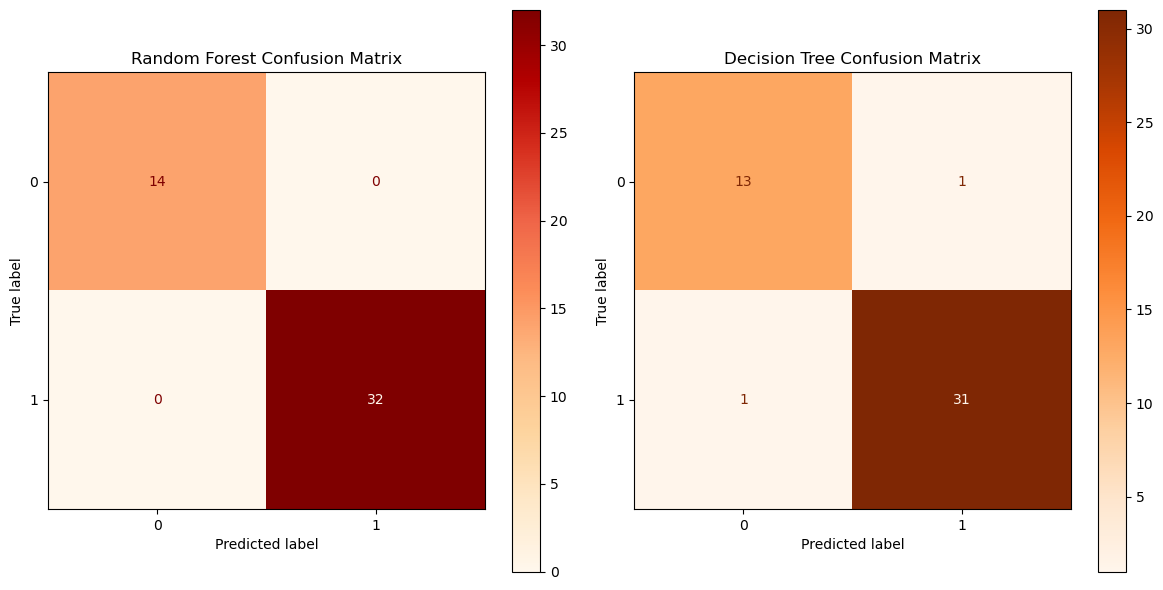

In [31]:
from sklearn.preprocessing import LabelBinarizer

# Binarize the output
lb = LabelBinarizer()
y_test_binarized = lb.fit_transform(y_test)

# Initialize the plot
plt.figure(figsize=(12, 8))
colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown']  # Add more colors if needed

# Random Forest ROC Curves
for i in range(y_test_binarized.shape[1]):  # One curve for each class
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], rf_model.predict_proba(X_test_scaled)[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i % len(colors)], lw=2, linestyle='-', 
             label=f'Random Forest - Class {lb.classes_[i]} (AUC = {roc_auc:.2f})')

# Decision Tree ROC Curves
for i in range(y_test_binarized.shape[1]):  # One curve for each class
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], dt_model.predict_proba(X_test_scaled)[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i % len(colors)], lw=2, linestyle='--', 
             label=f'Decision Tree - Class {lb.classes_[i]} (AUC = {roc_auc:.2f})')

# Plot diagonal line
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier line
plt.title('ROC Curves (Multiclass - Random Forest vs Decision Tree)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid()
plt.show()

from sklearn.metrics import ConfusionMatrixDisplay

# Plot confusion matrices
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Random Forest Confusion Matrix
ConfusionMatrixDisplay.from_estimator(rf_model, X_test_scaled, y_test, ax=ax[0], cmap="OrRd")
ax[0].set_title('Random Forest Confusion Matrix')

# Decision Tree Confusion Matrix
ConfusionMatrixDisplay.from_estimator(dt_model, X_test_scaled, y_test, ax=ax[1], cmap="Oranges")
ax[1].set_title('Decision Tree Confusion Matrix')

plt.tight_layout()
plt.show()



### KNN

In [32]:
data = result_df.copy()
print(data['cell_type'].unique())

['EXC' 'VIP' 'SST' 'PV']


In [33]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold,cross_val_predict

# We remove the Excitatory cells since we focus on the subdivision of the inhibitory cortical neurons.
inhib_cells = {'SST', 'VIP', 'PV'}
print(data.columns)
X = data[data['cell_type'].isin(inhib_cells)]
y = X['cell_type']
#print(X['cell_type_y'])
X = X.drop(columns=['cell_id', 'cell_type']) 
#X = X.drop(columns=['cell_id', 'cell_type_x', 'cell_type_y']) 
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y) 

# KNN avec de la cross 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# 4 classe donc 4 
knn_model = KNeighborsClassifier(n_neighbors=4)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(knn_model, X_scaled, y_encoded, cv=cv, scoring='accuracy')
print(f"Cross-Validation Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")


#on peut entrainer sur le full dataset
knn_model.fit(X_scaled, y_encoded)
y_pred = cross_val_predict(knn_model, X_scaled, y_encoded, cv=cv)
print("\nClassification Report (Cross-Validated Predictions):")
print(classification_report(y_encoded, y_pred, target_names=label_encoder.classes_))


Index(['cell_id', 'cell_type', 'firing_rate', 'ap_threshold', 'ap_duration',
       'mean_vm', 'std_vm', 'fft_low', 'fft_high', 'vm_amplitude_pre',
       'ap_fr_pre', 'wp_amplitude_pre', 'delta_ap', 'delta_vm', 'delta_wp'],
      dtype='object')
Cross-Validation Accuracy: 0.8337 ± 0.0662

Classification Report (Cross-Validated Predictions):
              precision    recall  f1-score   support

          PV       0.88      0.89      0.88        47
         SST       0.82      0.93      0.87        72
         VIP       0.79      0.44      0.56        25

    accuracy                           0.83       144
   macro avg       0.83      0.75      0.77       144
weighted avg       0.83      0.83      0.82       144



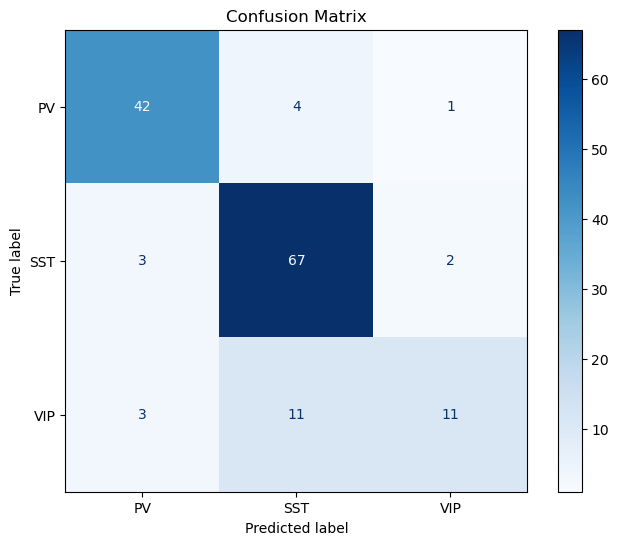

In [34]:
cm = confusion_matrix(y_encoded, y_pred, labels=np.unique(y_encoded))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues', colorbar=True)

plt.title("Confusion Matrix")
plt.show()


/Users/lilly-flore/miniconda3/envs/bio482/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


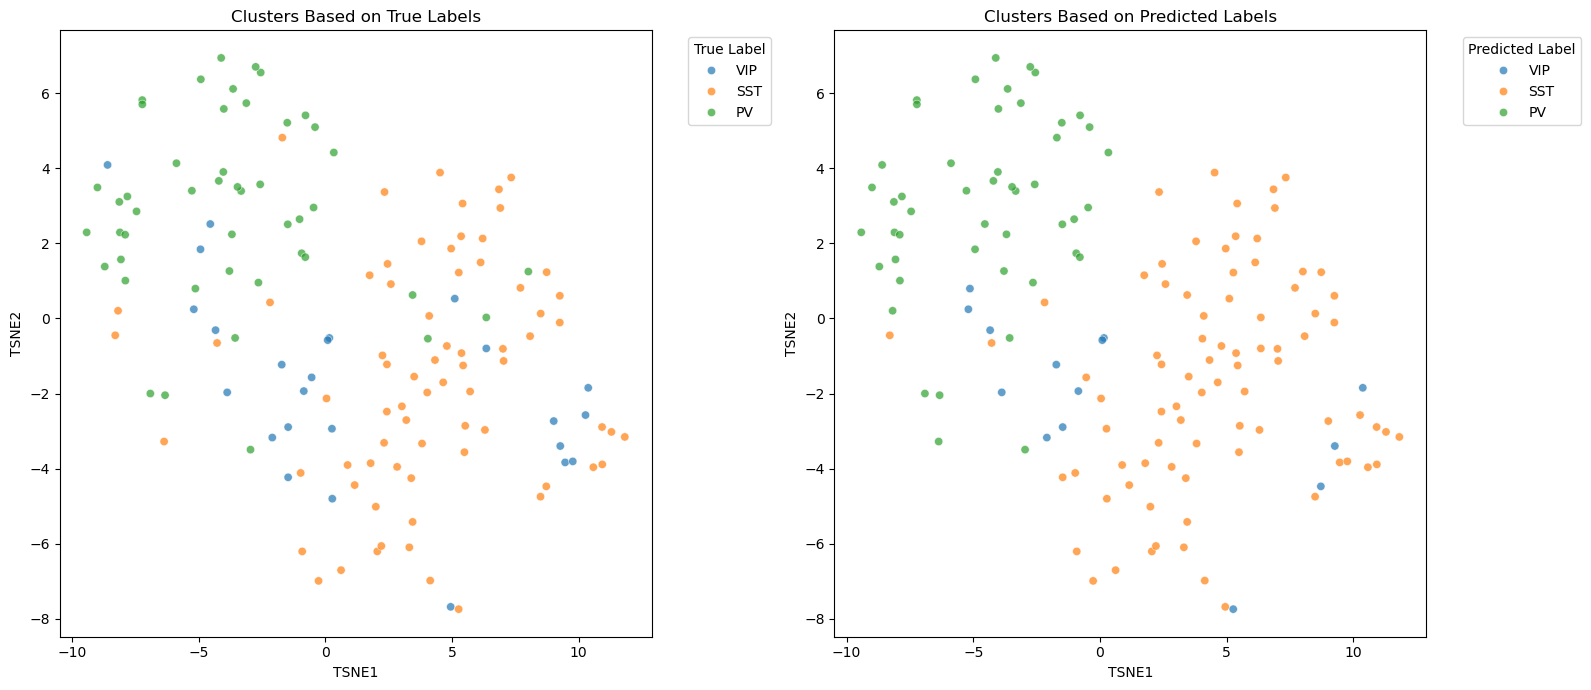

In [35]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_scaled)

cell_names_true = label_encoder.inverse_transform(y_encoded)  
cell_names_pred = label_encoder.inverse_transform(y_pred)  

tsne_data = pd.DataFrame({
    'TSNE1': X_tsne[:, 0],
    'TSNE2': X_tsne[:, 1],
    'True Label': cell_names_true,
    'Predicted Label': cell_names_pred
})

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

#  vrai fait els vraies choses
sns.scatterplot(
    data=tsne_data, 
    x='TSNE1', 
    y='TSNE2', 
    hue='True Label', 
    palette='tab10', 
    ax=axes[0], 
    alpha=0.7
)
axes[0].set_title("Clusters Based on True Labels")
axes[0].legend(title='True Label', bbox_to_anchor=(1.05, 1), loc='upper left')

# Predit
sns.scatterplot(
    data=tsne_data, 
    x='TSNE1', 
    y='TSNE2', 
    hue='Predicted Label', 
    palette='tab10', 
    ax=axes[1], 
    alpha=0.7
)
axes[1].set_title("Clusters Based on Predicted Labels")
axes[1].legend(title='Predicted Label', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


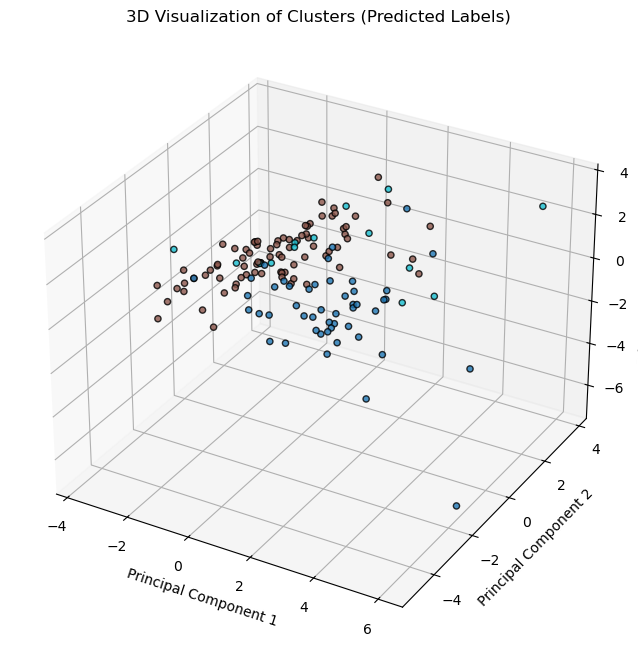

In [36]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

pca = PCA(n_components=4)
X_pca = pca.fit_transform(X_scaled)


pca_data = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'PC3': X_pca[:, 2],
    'True Label': y_encoded,
    'Predicted Label': y_pred
})


fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    pca_data['PC1'], pca_data['PC2'], pca_data['PC3'], 
    c=pca_data['Predicted Label'], cmap='tab10', alpha=0.8, edgecolor='k'
)
ax.set_title("3D Visualization of Clusters (Predicted Labels)")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")
plt.show()


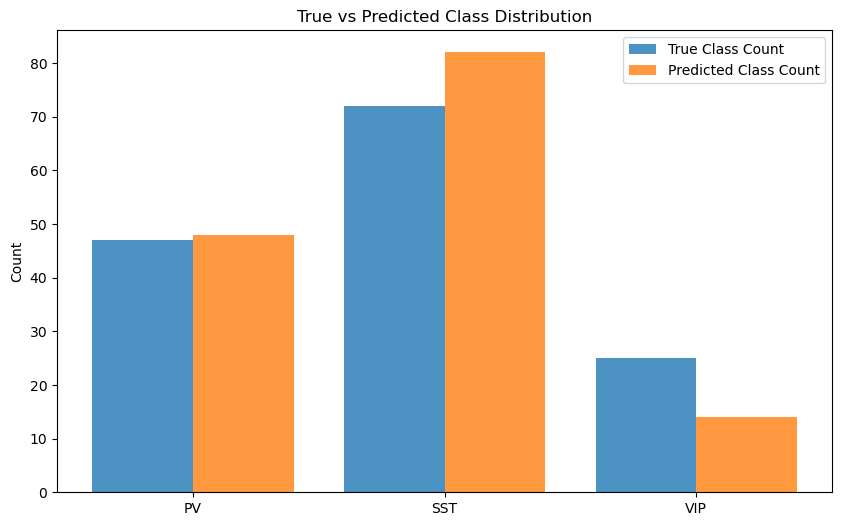

In [37]:
true_class_counts = np.bincount(y_encoded)
predicted_class_counts = np.bincount(y_pred, minlength=len(true_class_counts))


labels = label_encoder.classes_
x = np.arange(len(labels))

plt.figure(figsize=(10, 6))
plt.bar(x - 0.2, true_class_counts, width=0.4, label="True Class Count", alpha=0.8)
plt.bar(x + 0.2, predicted_class_counts, width=0.4, label="Predicted Class Count", alpha=0.8)
plt.xticks(x, labels)
plt.ylabel("Count")
plt.title("True vs Predicted Class Distribution")
plt.legend()
plt.show()


/Users/lilly-flore/miniconda3/envs/bio482/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


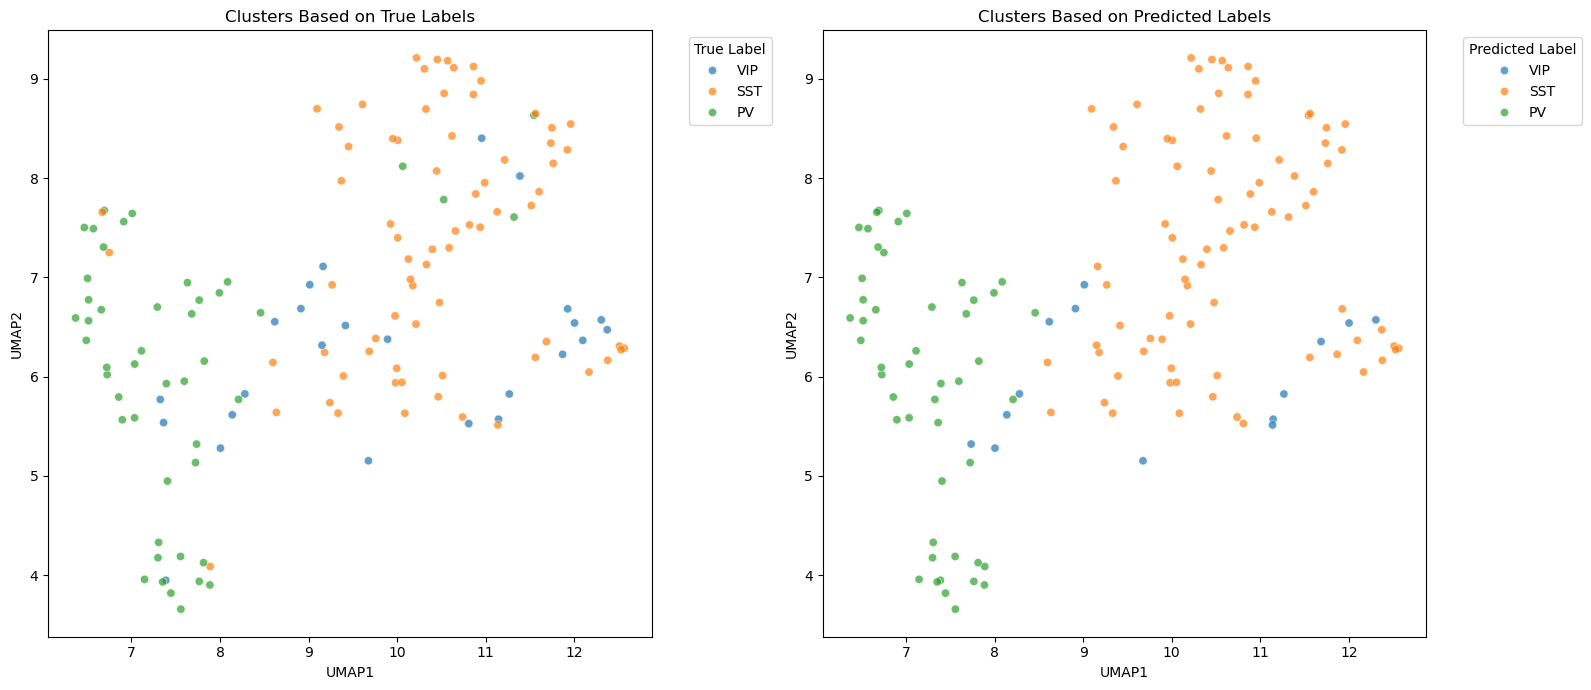

In [38]:
import umap


umap_reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_reducer.fit_transform(X_scaled)
cell_names_true = label_encoder.inverse_transform(y_encoded)  
cell_names_pred = label_encoder.inverse_transform(y_pred)    

umap_data = pd.DataFrame({
    'UMAP1': X_umap[:, 0],
    'UMAP2': X_umap[:, 1],
    'True Label': cell_names_true,
    'Predicted Label': cell_names_pred
})


fig, axes = plt.subplots(1, 2, figsize=(16, 7))
sns.scatterplot(
    data=umap_data, 
    x='UMAP1', 
    y='UMAP2', 
    hue='True Label', 
    palette='tab10', 
    ax=axes[0], 
    alpha=0.7
)
axes[0].set_title("Clusters Based on True Labels")
axes[0].legend(title='True Label', bbox_to_anchor=(1.05, 1), loc='upper left')
sns.scatterplot(
    data=umap_data, 
    x='UMAP1', 
    y='UMAP2', 
    hue='Predicted Label', 
    palette='tab10', 
    ax=axes[1], 
    alpha=0.7
)
axes[1].set_title("Clusters Based on Predicted Labels")
axes[1].legend(title='Predicted Label', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()
